In [8]:
import numpy as np
from scipy.linalg import svd

In [9]:
def leverage_scores_sampling(A, k):
    # compute the SVD of A
    U, s, Vt = svd(A, full_matrices=False)
    # compute the leverage scores
    leverage_scores = [ np.sum(U[i,:]**2) for i in range(10) ]
    # normalize the scores
    # p = leverage_scores / np.sum(leverage_scores)
    return leverage_scores

In [10]:
np.random.seed(123)
A = np.random.randn(100, 10)
leverage_scores_sampling(A, 10)

[0.16614325103993507,
 0.14072467406012715,
 0.10687198307998205,
 0.12249011657240125,
 0.1330636212217248,
 0.12042624931531672,
 0.11185912757040008,
 0.13973446013442065,
 0.14444584058213153,
 0.07415566252704656]

### Another way to get leverage score

In [11]:
A_tA_inv = np.linalg.pinv(A.T @ A)
# vetorize the following operator for computing the leverage scores
leverage_scores = [ A[i,:] @ A_tA_inv @ A[i,:].T for i in range(10) ]
leverage_scores

[0.1661432510399352,
 0.14072467406012726,
 0.10687198307998211,
 0.12249011657240118,
 0.13306362122172474,
 0.12042624931531673,
 0.11185912757040008,
 0.13973446013442073,
 0.1444458405821314,
 0.07415566252704653]

Target:
$$\text{Span}\{A^i\}_{i=1}^n \approx \text{Span}\{A^i\}_{i=1}^k,\quad k<n$$
contribution of leverage score to select good columns:
$$
\begin{align*}
  A &= U\Sigma V^T\\
  \begin{pmatrix}Av_1 & Av_2 & \cdots\end{pmatrix} &= \begin{pmatrix}\sigma_1 u_1 &\sigma_2 u_2 &\cdots\end{pmatrix}\\
  \begin{pmatrix}\sum v_{1i}A^i & \sum v_{2i}A^i & \cdots\end{pmatrix} &= \begin{pmatrix}\sigma_1 u_1 &\sigma_2 u_2 &\cdots\end{pmatrix}
\end{align*}
$$

Hence, $v_{11}^2+v_{21}^2+\cdots$ sum the all contribute of $A^1$ column to generate the basis for $\mathcal{B}=\{\sigma_1 u_1 ,\sigma_2 u_2 ,\cdots\}$ (where $\mathcal{B}$ is the same as original basis of $\{A^i\}$)

## Finding Geometry

### manifold structure

Suppose, I have a dataset which represent a manifold type of structure (e.g., $\mathbb R^n$ dimensional ball). Now, if we choose $m$ points for this ball then the matrix representation is a $\mathbb R^{m\times n}$ matrix. 

- Is there any systematic way to removes some points from this dataset which will still preserve the manifold structure?

Because after forming the matrix, we destroy the manifold representation (what I understand). And the intrinsic structure was somewhere hidden in the matrix. How to explore it with using minimum data points?

### Constructing canonical manifold

Can we construct manifold from our dataset? 

- what will be the set on which the topology needed to be defined?
- what will be the notion of neighborhood, compactness? 
- what will be the atlas?

$$\textrm{vector space}\stackrel{?}{\rightarrow}\textrm{manifold}$$

### Existing manifold learning Approach

#### does graph represent a manifold?

First, they create a representation of the data, which is typically done by constructing a k-nearest neighbour graph capturing its local structure. Second, they compute a low-dimensional representation (embedding) of the data trying to preserve the structure of the original data. This is where most manifold learning methods differ. For example, **Isomap** tries to preserve the graph geodesic distance, **Locally Linear Embedding** finds a local representation of adjacent points, and **Laplacian eigenmaps** use the eigenfunctions of the graph Laplacian operator as the low-dimensional embedding. This new representation “flattens” the original non-Euclidean structure into a Euclidean space that is easier to deal with. Third, once the representation is computed, a machine learning algorithm (typically clustering) is applied to it.


![](./images/manifold.png)

[Source](https://towardsdatascience.com/manifold-learning-2-99a25eeb677d)

A different concept commonly used in differential geometry is that of geometric flows, evolving the properties of the domain itself. This idea was adopted by my PhD advisor Ron Kimmel and his co-authors in the 1990s in the field of image processing. They modelled images as manifolds embedded in a joint *positional and colour* space and evolved them by a PDE minimising the harmonic energy of the embedding. Such a PDE, named Beltrami flow, has the form of isotropic non-euclidean diffusion and produces edge-preserving image denoising.

- [Beltrami Flow and Neural Diffusion on Graphs](https://arxiv.org/pdf/2110.09443.pdf)
- [k-Nearest Neighbors: From Global to Local](https://arxiv.org/pdf/1701.07266.pdf)
- https://towardsdatascience.com/the-wavelet-transform-e9cfa85d7b34
- https://medium.com/@steinsfu/diffusion-model-clearly-explained-cd331bd41166

Why not think to project our graph to some $\mathbb R^k$ and refinement the $\mathbb R^k$ by Algebraic property of original datas. $$k\stackrel{\text{Graph}}{\rightarrow}\mathbb R^k$$
Topologists study spaces by assigning algebraic objects called invariants to them. They may be as simple as an integer, but they are often more complicated algebraic structures. For data analysis, the invariant of choice is persistent homology.

- [topology-looks-for-the-patterns-inside-big-data](https://theconversation.com/topology-looks-for-the-patterns-inside-big-data-39554)
- [Extracting Topological Features from Big Data Using Persistent Density Entropy](https://www.researchgate.net/publication/331677615_Extracting_Topological_Features_from_Big_Data_Using_Persistent_Density_Entropy)

Problem to complete this idea: 

- How to project a non planar graph to $\mathbb R^k$? -> https://math.stackexchange.com/questions/3745315/can-a-graph-be-non-planar-in-3d
- https://math.stackexchange.com/questions/4256546/requirements-for-embedding-a-graph-in-n-dimensional-euclidean-space

### coding experiment

In [12]:
import mpl_toolkits.mplot3d 

In [13]:
from sklearn.datasets import make_swiss_roll
n_samples = 1500
noise = 0.05
X, _ = make_swiss_roll(n_samples, noise=noise)
X.shape

(1500, 3)

In [ ]:
import plotly.graph_objs as go
import plotly.io as pio

fig = go.Figure(data=[go.Scatter3d(x=X[:, 0], y=X[:, 1], z=X[:, 2], mode='markers',
                                   marker=dict(color=X[:, 2], colorscale='Viridis', opacity=0.8))])
fig.update_layout(scene=dict(xaxis_title='X axis', yaxis_title='Y axis', zaxis_title='Z axis'),
                  margin=dict(l=0, r=0, b=0, t=0))

pio.show(fig)

In [22]:
from sklearn.neighbors import kneighbors_graph
from scipy.sparse import csr_matrix

# create k-nearest neighbors graph
k = 10
knn_graph = kneighbors_graph(X, k, mode='connectivity', include_self=False)

# convert graph to adjacency matrix
adj_matrix = csr_matrix(knn_graph)

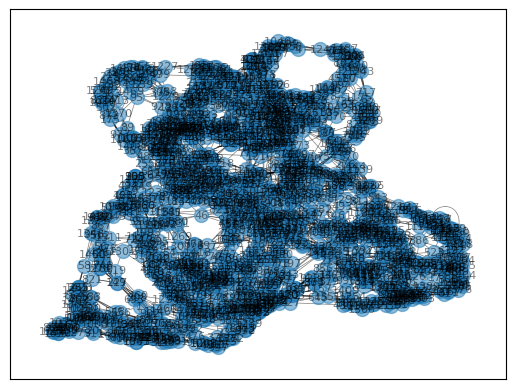

In [32]:
import networkx as nx
import matplotlib.pyplot as plt

# convert adjacency matrix to networkx graph
graph = nx.Graph(adj_matrix)

# plot the graph
nx.draw_networkx(graph, arrows=True, with_labels=True, node_size=100, alpha=0.5, width=0.5, font_size=8, font_color='k')
# nx.draw(g,with_labels=True)
# plt.draw()
# plt.show()

Does the resulting graph related with any manifold?

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits.mplot3d import Axes3D
from pydiffmap import diffusion_map as dm

%matplotlib inline

In [3]:
# set parameters
length_phi = 15   #length of swiss roll in angular direction
length_Z = 15     #length of swiss roll in z direction
sigma = 0.1       #noise strength
m = 10000         #number of samples

# create dataset
phi = length_phi*np.random.rand(m)
xi = np.random.rand(m)
Z = length_Z*np.random.rand(m)
X = 1./6*(phi + sigma*xi)*np.sin(phi)
Y = 1./6*(phi + sigma*xi)*np.cos(phi)

swiss_roll = np.array([X, Y, Z]).transpose()

# check that we have the right shape
print(swiss_roll.shape)

(10000, 3)


In [4]:
# initialize Diffusion map object.
neighbor_params = {'n_jobs': -1, 'algorithm': 'ball_tree'}

mydmap = dm.DiffusionMap.from_sklearn(n_evecs=2, k=200, epsilon='bgh', alpha=1.0, neighbor_params=neighbor_params)
# fit to data and return the diffusion map.
dmap = mydmap.fit_transform(swiss_roll)

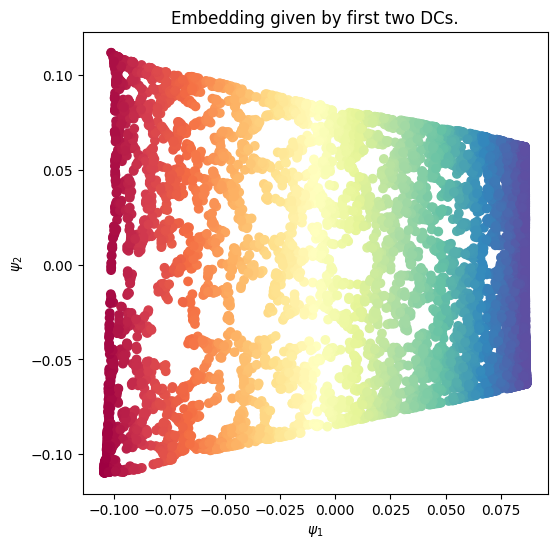

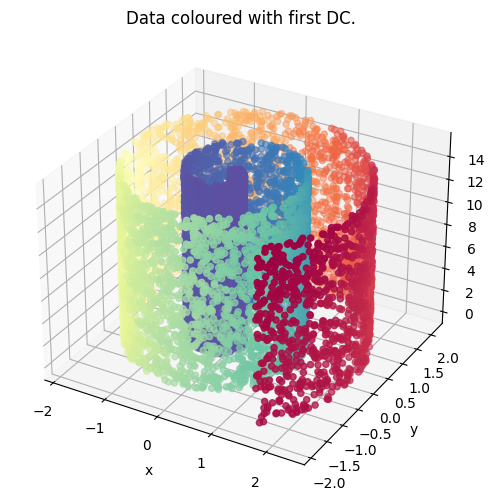

In [5]:
from pydiffmap.visualization import embedding_plot, data_plot

embedding_plot(mydmap, scatter_kwargs = {'c': dmap[:,0], 'cmap': 'Spectral'})
data_plot(mydmap, dim=3, scatter_kwargs = {'cmap': 'Spectral'})

plt.show()